# Building neural networks in numpy and scikit-learn

# Neural networks

Artificial neural networks are computational systems that can learn to perform tasks by considering examples,
generally without being programmed with any task-specific rules. It is supposed to mimic a biological system, wherein neurons interact by sending signals in the form of mathematical functions between layers. All layers can contain an arbitrary number of neurons, and each connection is represented by a weight variable.  
  
In this tutorial we will build a feed-forward neural network, where information moves in only in direction:
forward through the layers. Each neuron or *node* is represented by a circle, while arrows display the connections
between the nodes and indicate the direction of information flow. Each node in a layer is connected to all nodes in the subsequent layer, which makes this a so-called *fully-connected* feed-forward neural network.

![FFNN](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)  
Via [Wikipedia](https://en.wikipedia.org/wiki/File:Colored_neural_network.svg)

# Prerequisites

To follow this tutorial we require an installation of Python with the numerical package **numpy**, either:  
1) Python 2.7.x  
2) Python 3.5.x or greater  
  
With a version of Numpy 1.0.x or greater.  
We will also use the packages **matplotlib**, **scikit-learn**, **Tensorflow** and **Keras**, though these are not strictly necessary.  
To open and run this notebook you also need an installation of **IPython** and **Jupyter Notebook**.  
  
# Anaconda
Anaconda is a free and open source Python and R distribution, that aims to simplify package management and deployment. Anaconda comes with more than 1000 data packages, as well as the Conda package and package and virtual environment manager. Anaconda is available on Linux, OS X and Windows systems, and contains nearly all prerequisite software, and comes highly recommended.  
If Anaconda is installed you can install Tensorflow and Keras using:  
  
```conda install tensorflow```  
```conda install keras```  
  
(You may run into minor problems with conflicting package versions)  
  
# Pip package manager
If you do not wish to install Anaconda you may download Python from [here](https://www.python.org/downloads/),
or you can use package managers like **brew**, **apt**, **pacman**,...  
Python distributions come with their own package manager, **pip**, and once you have Python installed
you can run the following command:  
  
```pip install numpy matplotlib scikit-learn ipython jupyter```  
  
To install Tensorflow follow the instructions [here](https://www.tensorflow.org/install/).  
After you have installed tensorflow you can install keras:  
  
```pip install keras```

![Python](https://imgs.xkcd.com/comics/python_environment.png)  
Via [xkcd](https://xkcd.com/1987/)

# Workflow
  
One can identify a set of key steps when using neural networks to solve supervised learning problems:  
  
**
1) Collect and pre-process data  
2) Define model and architecture  
3) Choose cost function and optimizer  
4) Train the model  
5) Evaluate model performance on test data  
6) Adjust hyperparameters (if necessary, network architecture)
**

# 1) Collect and pre-process data
  
In this tutorial we will be using the MNIST dataset, which is readily available through the **scikit-learn**
package. You may also find it for example [here](http://yann.lecun.com/exdb/mnist/).  
The **MNIST** (Modified National Institute of Standards and Technology) database is a large database
of handwritten digits that is commonly used for training various image processing systems.  
The MNIST dataset consists of 70 000 images of size 28x28 pixels, each labeled from 0 to 9.  
  
To feed data into a feed-forward neural network we need to represent the inputs as a feature matrix $X = [n_{inputs}, 
n_{features}]$.  
Each row represents an **input**, in this case a handwritten digit, and each column represents a **feature**, in this case a pixel.  
The correct answers, also known as **labels** or **targets** are represented as a 1D array of integers $Y = [n_{inputs}] = [5, 3, 1, 8,...]$.  
  
Say I wanted to build a neural network using supervised learning to predict Body-Mass Index (BMI) from
measurements of height (in m)  
and weight (in kg). If I had measurements of 5 people the feature matrix could be for example:  
  
$$ X = \begin{bmatrix}
1.85 & 81\\
1.71 & 65\\
1.95 & 103\\
1.55 & 42\\
1.63 & 56
\end{bmatrix} ,$$  
  
and the targets would be:  
  
$$ Y = (23.7, 22.2, 27.1, 17.5, 21.1) $$  
  
Since each input image is a 2D matrix, we need to flatten the image (i.e. "unravel" the 2D matrix into a 1D array)  
to turn the data into a feature matrix. This means we lose all spatial information in the image, such as locality and translational invariance ([explanation](https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-neural-netwo))  
More complicated architectures such as Convolutional Neural Networks can take advantage
of such information, and is most commonly applied when analyzing images.

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


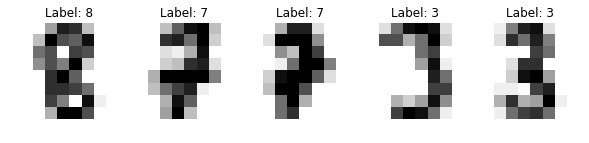

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

#ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()


# Train and test datasets

Performing analysis before partitioning the dataset is a major error, that can lead to incorrect conclusions  
(see "Bias-Variance Tradeoff", for example [here](https://ml.berkeley.edu/blog/2017/07/13/tutorial-4/)).  
  
We will reserve $80 \%$ of our dataset for training and $20 \%$ for testing.  
  
It is important that the train and test datasets are drawn randomly from our dataset, to ensure
no bias in the sampling.  
Say you are taking measurements of weather data to predict the weather in the coming 5 days.
You don't want to train your model on measurements taken from the hours 00.00 to 12.00, and then test it on data
collected from 12.00 to 24.00.

In [2]:
from sklearn.model_selection import train_test_split

# one-liner from scikit-learn library
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

# equivalently in numpy
def train_test_split_numpy(inputs, labels, train_size, test_size):
    n_inputs = len(inputs)
    inputs_shuffled = inputs.copy()
    labels_shuffled = labels.copy()
    
    np.random.shuffle(inputs_shuffled)
    np.random.shuffle(labels_shuffled)
    
    train_end = int(n_inputs*train_size)
    X_train, X_test = inputs_shuffled[:train_end], inputs_shuffled[train_end:]
    Y_train, Y_test = labels_shuffled[:train_end], labels_shuffled[train_end:]
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = train_test_split_numpy(inputs, labels, train_size, test_size)

# 2) Define model and architecture
  
Our simple feed-forward neural network will consist of an **input** layer, a single **hidden** layer and an **output** layer. The activation $y$ of each neuron is a weighted sum of inputs, passed through an activation function:  
  
$$ z = \sum_{i=1}^n w_i x_i ,$$
  
$$ y = f(z) ,$$
  
where $f$ is the activation function, $x_i$ represents input from neuron $i$ in the preceding layer
and $w_i$ is the weight to neuron $i$.  
The activation of the neurons in the input layer is just the features (e.g. a pixel value).  
  
The simplest activation function for a binary classifier (e.g. two classes, 0 or 1, cat or not cat)
is the **Heaviside** function:
  
$$ f(z) = 
\begin{cases}
1,  &  z > 0\\
0,  & \text{otherwise}
\end{cases}
$$
  
A feed-forward neural network with this activation is known as a **perceptron**.  
This activation can be generalized to $k$ classes (using e.g. the *one-against-all* strategy), 
and we call these architectures **multiclass perceptrons**.  
  
However, it is now common to use the terms Single Layer Perceptron (SLP) (1 hidden layer) and  
Multilayer Perceptron (MLP) (2 or more hidden layers) to refer to feed-forward neural networks with any activation function.  
  
Typical choices for activation functions include the sigmoid function, hyperbolic tangent, and Rectified Linear Unit (ReLU).  
We will be using the sigmoid function $\sigma(x)$:  
  
$$ f(x) = \sigma(x) = \frac{1}{1 + e^{-x}} ,$$
  
which is inspired by probability theory (see logistic regression) and was most commonly used until about 2011.
  
# Layers
  
**Input**:  
Since each input image has 8x8 = 64 pixels or features, we have an input layer of 64 neurons.  
  
**Hidden layer**:  
We will use 25 neurons in the hidden layer receiving input from the neurons in the input layer.  
Since each neuron in the hidden layer is connected to the 64 inputs we have 64x25 = 1600 weights to the hidden layer.  
  
**Output**:  
If we were building a binary classifier, it would be sufficient with a single neuron in the output layer,
which could output 0 or 1 according to the Heaviside function. This would be an example of a **hard** classifier, meaning it outputs the class of the input directly. However, if we are dealing with noisy data it is often beneficial to use a **soft** classifier, which outputs the probability of being in class 0 or 1.  
  
For a soft binary classifier, we could use a single neuron and interpret the output as either being the probability of being in class 0 or the probability of being in class 1. Alternatively we could use 2 neurons, and interpret each neuron as the probability of being in each class.  
  
Since we are doing multiclass classification, with 10 categories, it is natural to use 10 neurons in the output layer. We number the neurons $j = 0,1,...,9$. The activation of each output neuron $j$ will be according to the **softmax** function:  
  
$$ P(\text{class $j$} \mid \text{input $\boldsymbol{x}$}) = \frac{e^{\boldsymbol{x}^T \boldsymbol{w}_j}}
{\sum_{k=0}^{9} e^{\boldsymbol{x}^T \boldsymbol{w}_k}} ,$$  
  
i.e. each neuron $j$ outputs the probability of being in class $j$ given an input from the hidden layer $\boldsymbol{x}$, with $\boldsymbol{w}_j$ the weights of neuron $j$ to the inputs.  
The denominator is a normalization factor to ensure the outputs sum up to 1.  
The exponent is just the weighted sum of inputs as before:  
  
$$ z_j = \sum_{i=1}^n w_ {ij} x_i = \boldsymbol{x}^T \boldsymbol{w}_j .$$  
  
Since each neuron in the output layer is connected to the 25 inputs from the hidden layer we have 25x10 = 250
weights to the output layer.
  
# Weights and biases
  
Typically weights are initialized with small values distributed around zero, drawn from a uniform
or normal distribution. Setting all weights to zero means all neurons give the same output, making the network useless.  
  
Adding a bias value to the weighted sum of inputs allows the neural network to represent a greater range
of values. Without it, any input with the value 0 will be mapped to zero. The bias unit has an output of 1, and a weight to each neuron $j$, $b_j$:  
  
$$ z_j = \sum_{i=1}^n w_ {ij} x_i + 1\cdot b_j = \boldsymbol{x}^T \boldsymbol{w}_j + b_j .$$  
  
The bias weights $\boldsymbol{b}$ are often initialized to zero, but a small value like $0.01$ ensures all neurons have some output which can be backpropagated in the first training cycle.

![Bias](http://ufldl.stanford.edu/tutorial/images/Network331.png)  
Via [Stanford UFLDL](http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/)

In [3]:
# building our neural network

n_inputs, n_features = X_train.shape
n_hidden_neurons = 25
n_categories = 10

# we make the weights normally distributed using numpy.random.randn

# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)
hidden_bias = np.zeros(n_hidden_neurons) + 0.01

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_hidden_neurons) + 0.01

# Feed-forward pass
   
Since our data has the dimensions $X = (n_{inputs}, n_{features})$ and our weights to the hidden
layer have the dimensions  
$W_{hidden} = (n_{features}, n_{hidden})$,
we can easily feed the network all our training data in one go by taking the dot product  
  
$$ X^T W = (n_{inputs}, n_{hidden}),$$ 
  
and obtain a matrix that holds the weighted sum of inputs to the hidden layer
for each input image.  
  
For each input image we calculate a weighted sum of inputs (pixels) to each neuron $j$ in the hidden layer:  
  
$$ z_{j}^{hidden} = \sum_{i=1}^{n_{features}} w_{ij}^{hidden} x_i + b_{j}^{hidden} = \boldsymbol{x}^T \boldsymbol{w}_{j}^{hidden} + b_{j}^{hidden} ,$$
  
this is then passed through our activation function  
  
$$ a_{j}^{hidden} = f(z_{j}^{hidden}) .$$  
  
We calculate a weighted sum of inputs (activations in the hidden layer) to each neuron $j$ in the output layer:  
  
$$ z_{j}^{output} = \sum_{i=1}^{n_{hidden}} w_{ij}^{output} a_{i}^{hidden} + b_{j}^{output} = (\boldsymbol{a}^{hidden})^T \boldsymbol{w}_{j}^{output} + b_{j}^{output} .$$  
  
Finally we calculate the output of neuron $j$ in the output layer using the softmax function:  
  
$$ a_{j}^{output} = \frac{\exp{(z_j^{output})}}
{\sum_{k=0}^{9} \exp{(z_k^{output})}} ,$$  

In [4]:
# setup the feed-forward pass

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z1 = np.dot(X, hidden_weights)
    # activation in the hidden layer
    a1 = sigmoid(z1)
    
    # weighted sum of inputs to the output layer
    z2 = np.dot(a1, output_weights)
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z2)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    return probabilities

probabilities = feed_forward(X_train)
print("probabilities = (n_inputs, n_categories) = " + str(probabilities.shape))
print("probability that image 0 is in category 0,1,2,...,9 = \n" + str(probabilities[0]))
print("probabilities sum up to: %.3f" % probabilities[0].sum())

# we obtain a prediction by taking the class with the highest likelihood
def predict(X):
    probabilities = feed_forward(X)
    return np.argmax(probabilities, axis=1)

predictions = predict(X_train)
print()
print("predictions = (n_inputs) = " + str(predictions.shape))
print("prediction for image 0: %d" % predictions[0])
print("correct label for image 0: %d" % Y_train[0])

probabilities = (n_inputs, n_categories) = (1437, 10)
probability that image 0 is in category 0,1,2,...,9 = 
[1.30129225e-04 1.83087264e-04 2.63322297e-04 2.14710870e-05
 9.24959091e-01 3.32452691e-05 6.96952013e-02 4.24138948e-05
 3.88303375e-03 7.89004626e-04]
probabilities sum up to: 1.000

predictions = (n_inputs) = (1437,)
prediction for image 0: 4
correct label for image 0: 9


# 3) Choose cost function and optimizer (needs some more work)
  
To measure how well our neural network is doing we need to introduce a cost function.  
We call the function that gives the error of a single output the **loss** function, and the function
that gives the total error of our network the **cost** function.
A typical choice for multiclass classification is the **cross-entropy** loss, also known as the negative log likelihood.  In multiclass classification it is common to treat each integer label as a so called **one-hot** vector:  
  
$$ y = 5 \quad \rightarrow \quad \boldsymbol{y} = (0, 0, 0, 0, 0, 1, 0, 0, 0, 0) ,$$  

  
$$ y = 1 \quad \rightarrow \quad \boldsymbol{y} = (0, 1, 0, 0, 0, 0, 0, 0, 0, 0) ,$$  
  
  
i.e. a binary bit string of length $K$, where $K = 10$ is the number of classes.  
If $\boldsymbol{x}_i$ is the $i$-th input (image), $y_{ik}$ refers to the $k$-th component of the $i$-th
output vector $\boldsymbol{y}_i$. The probability of $\boldsymbol{x}_i$ being in class $k$ is given by the softmax function:  
  
$$ P(y_{ik} = 1 \mid \boldsymbol{x}_i) = \frac{e^{\boldsymbol{x}_i^T \boldsymbol{w}_k}}
{\sum_{k'=0}^{K-1} e^{\boldsymbol{x}_i^T \boldsymbol{w}_{k'}}} $$  

The probability of not being in class $k$ is just $1 - P(y_{ik} = 1 \mid \boldsymbol{x}_i)$.  
For Maximum Likelihood Estimation (MLE) we choose the label with the largest probability.  
Denote the output label $\hat{y}$ and the correct label $y$, for example $\hat{y} = 5$. The likelihood that input $\boldsymbol{x}_i$
gives an output $\hat{y} = k$ is then
  
$$ P(\hat{y} = k \mid \boldsymbol{x}_i) = \prod_{k=0}^{K-1} [P(y_{ik} = 1 \mid \boldsymbol{x}_i)]^{y_{im}} 
\times [1 - P(y_{im} = 1 \mid \boldsymbol{x}_i)]^{1-y_{im}}$$  
  
A perfect classifier should give a $100 \%$ probability of the correct label, so the product
should just be 1. Otherwise, the likelihood should be smaller.  
If we take the log of this we can turn the product into a sum, which is often simpler to compute:  
  
$$ \log P(\hat{y} = k \mid \boldsymbol{x}_i) = \sum_{k=0}^{K-1} y_{ik} \log P(y_{ik} = 1 \mid \boldsymbol{x}_i) 
+ (1-y_{ik})\log (1 - P(y_{ik} = 1 \mid \boldsymbol{x}_i))$$  
  
For a perfect classifier this should just be $\log 1 = 0$. Otherwise we get a negative number.  
Since it is easier to think in terms of minimizing a positive number, we take our loss function
to be the negative log-likelihood:  
  
$$ \mathcal{L}(\boldsymbol{w}) = - \log P(\hat{y} = k \mid \boldsymbol{x}_i) $$  
  
We then take the average of the loss function over all input samples to define the cost function:  
$$ \begin{split} \mathcal{C}(\boldsymbol{w}) &= \frac{1}{N} \sum_{i=1}^N \mathcal{L}(\boldsymbol{w}) \\
 &= -\frac{1}{N}\sum_{i=1}^N \sum_{k=0}^{K-1} y_{ik} \log P(y_{ik} = 1 \mid \boldsymbol{x}_i) 
+ (1-y_{ik})\log (1 - P(y_{ik} = 1 \mid \boldsymbol{x}_i)) \end{split} .$$  
  
# Optimizing the cost function
  
Text.

# 4) Train the model
  
Backpropagation equations.

In [5]:
from keras.utils import to_categorical

Y_train_onehot, Y_test_onehot = to_categorical(Y_train), to_categorical(Y_test)

def feed_forward_train(X):
    # weighted sum of inputs to the hidden layer
    z1 = np.dot(X, hidden_weights)
    # activation in the hidden layer
    a1 = sigmoid(z1)
    
    # weighted sum of inputs to the output layer
    z2 = np.dot(a1, output_weights)
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z2)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    return a1, probabilities

def backpropagation(X, Y):
    a1, probabilities = feed_forward_train(X)
    
    # error in the output layer
    error_output = Y - probabilities
    # error in the hidden layer
    error_hidden = np.dot(error_output, output_weights.T) * a1 * (1 - a1)
    
    # gradients for the output layer
    output_weights_gradient = np.dot(a1.T, error_output)
    output_bias_gradient = np.sum(error_output)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.dot(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

predictions = predict(X_train)
print("old predictions for images 0-5: " + str(predictions[0:5]))
print("correct labels for images 0-5: " + str(Y_train[0:5]))
print()

eta = 0.1
for i in range(100):
    dWo, dBo, dWh, dBh = backpropagation(X_train, Y_train_onehot)
    
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh

predictions = predict(X_train)
print("new predictions for images 0-5: " + str(predictions[0:5]))
print("correct labels for images 0-5: " + str(Y_train[0:5]))
print()

Using TensorFlow backend.


old predictions for images 0-5: [4 4 9 4 4]
correct labels for images 0-5: [9 2 9 2 6]

new predictions for images 0-5: [0 0 0 0 0]
correct labels for images 0-5: [9 2 9 2 6]



/home/andreas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


# Full object-oriented implementation

# 5) Evaluate model performance on test data

# 6) Adjust hyperparameters (if necessary, network architecture)

# Scikit-learn implementation

# Tensorflow implementation

# Bonus: Keras

# Appendix

# Deriving the cost function

# Deriving the backpropagation equations